In [1]:
%reset -f 
from __future__ import absolute_import, print_function
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import signal
from matplotlib import rcParams
from scipy import io
import os

import locale
os.environ["PYTHONIOENCODING"] = "utf-8"

In [2]:
# parameters
gamma   = 1.6
sigma   = 1.6
mu      = 0.2
pho     = 1.5
delta   = 100.0
p       = 0.15 # 0-0.6
beta    = 3.0


# Spatial and temporal setting
length      = 2048.0      # Length of the physical landscape
n           = 4096       # Size of the 2D grid
endtime     = 100.0    # end time 400.0
dT          = 0.0005     # 
nplot       = 100
nsteps      = np.ceil(endtime/nplot/dT).astype(int)    # number of time steps
dX          = length/n      # Spatial step size
dY          = length/n      # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

# Setting up the OpenCL context
DeviceNr = 1   # 0 = GTX 960M
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

# Initial condition
S        = 1.0+np.zeros(n*n)
S_host   = S.astype(np.float64)
S_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=S_host)

CoefS    = np.zeros(n*n)
CoefS_host   = CoefS.astype(np.float64)
CoefS_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=CoefS_host)

BB       = np.random.rand(n*n)
B        = np.where(BB<0.1,2,0)
B_host   = B.astype(np.float64)
B_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=B_host)

# Load opencl function
with open('SpatialFunctions_iPy.cl', 'r',encoding='utf-8') as myfile:
   SpatialFunctions = myfile.read()

# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel
PassVars="gamma,sigma,mu,pho,delta,p,beta,dX,dY,dT,Grid_Width,Grid_Height"
PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""
for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

ComputeCode = """
///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////   

__kernel void SimulationKernel (__global float* S, __global float* B, __global float* CoefS)
{
    size_t current  = get_global_id(0);
    size_t row      = floor((float)current/(float)Grid_Width);
    size_t column   = current%Grid_Width;
    
        CoefS[current] = S[current] - beta*B[current];
        if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
            {
             float dSdt = p - (1.0 - pho*B[current])*S[current] - S[current]*S[current]*B[current] + delta*d2_dxy2(CoefS);
             float dBdt = gamma*S[current]/(1.0 + sigma*S[current])*B[current] - B[current]*B[current] - mu*B[current] + d2_dxy2(B);
             S[current] = S[current] + dSdt*dT;
             B[current] = B[current] + dBdt*dT;
            }
            
        // HANDLE Boundaries
        else 
            {
             PeriodicBoundaries(S);
             PeriodicBoundaries(B);
            }

} // End SimulationKernel
"""

program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 

#Ss=np.zeros((Grid_Width, Grid_Height, nplot))
#Bs=np.zeros((Grid_Width, Grid_Height, nplot))

# Set up simulation parameters
global_size = S_host.shape

Dir = 'test_p'+str(p)
if not os.path.exists(Dir):
    os.makedirs(Dir)

start_time = time.time()

# Starting the loop
for ii in range(1,nplot):
    # The simulation
    for jj in range(1,nsteps):      
        program.SimulationKernel(queue, global_size, None, S_g, B_g, CoefS_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, S_host, S_g)
    cl.enqueue_copy(queue, B_host, B_g)
    
    # We store the state of the system for <NumPlot> different times.
    Ss = S_host.reshape(Grid_Width, Grid_Height)
    Bs = B_host.reshape(Grid_Width, Grid_Height)
    io.savemat(Dir+'/Arid_'+str(ii)+'.mat',{'B':Bs})
    PB.value += 1 # signal to increment the progress bar

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

 Current grid dimensions: 4096 x 4096 cells

 Compute Device: AMD Radeon Pro Vega 56 Compute Engine

Progress :


FloatProgress(value=0.0, max=101.0)

 Simulation took      : 645.4 (s)


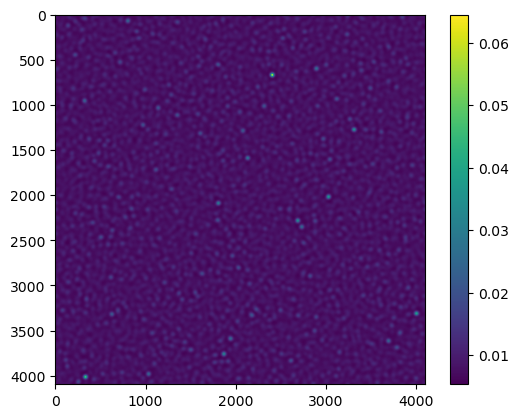

In [3]:
Bs = B_host.reshape(Grid_Width,Grid_Height)
plt.imshow(Bs)
plt.colorbar()

In [4]:
print(np.max(B_host))

0.06448602
